In [1]:
import sys
#!{sys.executable} -m pip install trimesh
#!{sys.executable} -m pip install porespy


In [2]:
from skimage.transform import pyramid_gaussian
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import closing, square, remove_small_objects, binary_opening, remove_small_holes, skeletonize_3d, skeletonize, disk, thin, medial_axis
from skimage.morphology import skeletonize, disk, ball
from skimage.filters import threshold_local, threshold_sauvola, threshold_niblack, threshold_otsu, rank
from skimage import data, measure

from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy import stats

import os
import numpy as np
import sys
import statistics
import math
import SimpleITK as sitk
import gc
from PIL import Image
import trimesh
import porespy as ps

from matplotlib import pyplot as plt 
%matplotlib inline


In [3]:
def GetFractalDimension(binary_mask):
    
    binary_mask_itk = sitk.GetImageFromArray(binary_mask.astype(float))

    counts = []
    sizes = []

    for a in range(1, 10):
        b = pow(2,a)

        binary_mask_itk.SetOrigin((0, 0, 0 ))
        binary_mask_itk.SetSpacing([1,1,1])
        
        size2D = (int(math.floor(binary_mask_itk.GetSize()[0]/2)), int(math.floor(binary_mask_itk.GetSize()[1]/2)), int(math.floor(binary_mask_itk.GetSize()[2]/2)))

        resampler = sitk.ResampleImageFilter()        
        resampler.SetSize(size2D)
        resampler.SetOutputSpacing([2,2,2])
        resampler.SetOutputOrigin((0.5, 0.5, 0.5))
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0)
        binary_mask_itk = resampler.Execute(binary_mask_itk)

        out = sitk.GetArrayFromImage(binary_mask_itk)
        count = np.count_nonzero(out) - np.count_nonzero(out == 1)
        all = out.shape[0] * out.shape[1] * out.shape[2]
        
        if count == all or count <= 1:
            break

        # print("{},{}".format(count, b))
        # print("{},{}".format(math.log(count), math.log(1/b)))
    
        counts.append(math.log(count))
        # sizes.append(math.log(1/b))
        sizes.append(math.log(b))
        
        #sitk.WriteImage(binary_mask_itk, 'S:/Tristan/binary_mask_itk.mha')
        
    plt.plot(counts, sizes, 'go')
    plt.show()
    

    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(sizes,counts)
        return slope
    except:
        print("An exception occurred") 
        return 0
    
    #print(slope)

In [4]:


def GetNumberOfHandles(binary_mask):
    stroma = ndimage.binary_fill_holes(binary_mask)
    stroma = np.pad(stroma, ((1,1),(1,1),(1,1)), 'constant', constant_values=0)

    regions, number_of_regions = ndimage.label(stroma)
    
    #verts, faces, normals, values = measure.marching_cubes_lewiner(stroma, level=None, spacing=(1.0, 1.0, 1.0), gradient_direction='descent', step_size=2, allow_degenerate=True, use_classic=False)
    verts, faces, normals, values = measure.marching_cubes(stroma, level=None, spacing=(1.0, 1.0, 1.0), gradient_direction='descent', step_size=1, allow_degenerate=True)
    
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=False)

    normals = mesh.vertex_normals
    values = normals[:,0]
    surface = (verts, faces, values)

    number_of_vertices = verts.shape[0]
    number_of_edges = (faces.shape[0] * 3)/2
    number_of_cells = faces.shape[0]
    number_of_boundaries = 0

    euler_number = number_of_vertices - number_of_edges + number_of_cells + number_of_boundaries
    
    
    # print("euler_number: {}".format(euler_number))
    # print("number_of_vertices: {}".format(number_of_vertices))
    # print("number_of_edges: {}".format(number_of_edges))
    # print("number_of_cells: {}".format(number_of_cells))
    # print("number_of_boundaries: {}".format(number_of_boundaries))
    # print("number_of_blobs: {}".format(number_of_blobs))
    
    number_of_handles = -(((number_of_vertices - number_of_edges + number_of_cells + number_of_boundaries)/2.0)-1) + (number_of_regions - 1)
    
    return number_of_handles





In [5]:

def GetThickness(binary_mask):
    #print("generating thickness map")
    thickness_map = ps.filters.local_thickness(binary_mask, mode='dt')
    thickness_map = np.float32(thickness_map)
    # thickness_map_itk = sitk.GetImageFromArray(thickness_map)
    # sitk.WriteImage(thickness_map_itk, 'UnitTestsOutputs/'+os.path.basename(file_name)[:-9]+'.mha')

    if(np.count_nonzero(binary_mask) > 0):
        average_thickness = 7.5 * np.sum(thickness_map) / np.count_nonzero(thickness_map)
        #print("np.count_nonzero(thickness_map) {}".format(np.count_nonzero(thickness_map)))

        mask = binary_mask == 0
        thickness_map_masked = np.ma.MaskedArray(thickness_map, mask)
        standard_deviation_thickness = 7.5 * thickness_map_masked.std()
        
        mask = None
        thickness_map_masked = None
    else:
        average_thickness = 0
        standard_deviation_thickness = 0
        
    del thickness_map
    
    return (average_thickness, standard_deviation_thickness)

    

In [6]:
def Run(file_name):
    print(file_name)
    #global mask
    #global mask_itk

    #mask_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")
    mask_itk = sitk.ReadImage(file_name)
    # sitk.WriteImage(mask_itk, 'mask_itk.nii')
    mask = sitk.GetArrayFromImage(mask_itk)
    #print(mask.shape)
    
    
    file_stroma_percentage = open('measurements_stroma_percentage.csv', 'a')
    file_stroma_percentage.write(os.path.basename(file_name)[:-9]+',')
    file_connectivity_density = open('measurements_connectivity_density.csv', 'a')
    file_connectivity_density.write(os.path.basename(file_name)[:-9]+',')
    file_fractal_dimension = open('measurements_fractal_dimension.csv', 'a')
    file_fractal_dimension.write(os.path.basename(file_name)[:-9]+',')
    file_average_thickness = open('measurements_average_thickness.csv', 'a')
    file_average_thickness.write(os.path.basename(file_name)[:-9]+',')
    file_standard_deviation_thickness = open('measurements_standard_deviation_thickness.csv', 'a')
    file_standard_deviation_thickness.write(os.path.basename(file_name)[:-9]+',')
    file_total_tissue_area = open('measurements_total_tissue_area.csv', 'a')
    file_total_tissue_area.write(os.path.basename(file_name)[:-9]+',')

    for i in range(1,9):
    
        tissue_count = np.count_nonzero(mask == i)
        stroma_count = np.count_nonzero(mask == i+11)
        stroma = mask == i+11
        total_tissue_area = 0.0075*0.0075*0.0075*(tissue_count + stroma_count)

        if(tissue_count != 0):
            stroma_percentage = 100 * (stroma_count / (tissue_count + stroma_count))

            print("stroma_percentage: {}".format(stroma_percentage))


            if(stroma_count != 0):
                number_of_handles = GetNumberOfHandles(stroma)
                connectivity_density = number_of_handles / total_tissue_area
                print("number_of_handles (#): {}".format(number_of_handles))
                print("connectivity_density (#/mm3): {}".format(connectivity_density))

                fractal_dimension = GetFractalDimension(stroma)
                print("fractal_dimension: {}".format(fractal_dimension))

                average_thickness, standard_deviation_thickness = GetThickness(stroma)
                print("average_thickness: {}".format(average_thickness))
                print("standard_deviation: {}".format(standard_deviation_thickness))
                print("----------------------------------------------------------------")
            else:
                number_of_handles = 0
                connectivity_density = 0
                fractal_dimension = 0
                average_thickness = 0
                standard_deviation_thickness = 0
                
        else:
            stroma_percentage = -1
            number_of_handles = -1
            connectivity_density = -1
            fractal_dimension = -1
            average_thickness = -1
            standard_deviation_thickness = -1


        file_stroma_percentage.write( str(stroma_percentage)+',')
        file_connectivity_density.write(str(connectivity_density)+',')
        file_fractal_dimension.write(str(fractal_dimension)+',')
        file_average_thickness.write(str(average_thickness)+',')
        file_standard_deviation_thickness.write(str(standard_deviation_thickness)+',')
        file_total_tissue_area.write(str(total_tissue_area)+',')
        
    
    file_stroma_percentage.write('\n')
    file_connectivity_density.write('\n')
    file_fractal_dimension.write('\n')
    file_average_thickness.write('\n')
    file_standard_deviation_thickness.write('\n')
    file_total_tissue_area.write('\n')
        
    file_stroma_percentage.close()
    file_connectivity_density.close()
    file_fractal_dimension.close()
    file_average_thickness.close()
    file_standard_deviation_thickness.close()
    file_total_tissue_area.close()
    

    print("done")
    del stroma
    del mask
    gc.collect()

In [7]:

#Run('UnitTests/50x50_line.mha')
#Run('UnitTests/50x50_plane.mha')
#Run('UnitTests/50x50_sphere2.mha')
#Run('UnitTests/50x50_sphere.mha')
#Run('UnitTests/10x10_double_mask.mha')
#Run('UnitTests/10x10_single_mask.mha')
# Run('UnitTests/10x10_double_mask2.mha')
# Run('UnitTests/50x50_all_outer.mha')
#Run('UnitTests/50x50_strange.mha')
# Run('UnitTests/50x50_cube.mha')
#Run('UnitTests/50x50_plane_4.mha')
#Run('UnitTests/50x50_plane_5.mha')
#Run("../../Storage/segmentations/" + "20190911_PDX_STG316_gfp_100x15um" + ".nii")


In [8]:
def RunTotal(file_name):
    print(file_name)
    #global mask
    #global mask_itk

    #mask_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")
    mask_itk = sitk.ReadImage(file_name)
    # sitk.WriteImage(mask_itk, 'mask_itk.nii')
    mask = sitk.GetArrayFromImage(mask_itk)
    #print(mask.shape)
    
    
    file_stroma_percentage = open('total_measurements_stroma_percentage.csv', 'a')
    file_stroma_percentage.write(os.path.basename(file_name)[:-9]+',')
    file_connectivity_density = open('total_measurements_connectivity_density.csv', 'a')
    file_connectivity_density.write(os.path.basename(file_name)[:-9]+',')
    file_fractal_dimension = open('total_measurements_fractal_dimension.csv', 'a')
    file_fractal_dimension.write(os.path.basename(file_name)[:-9]+',')
    file_average_thickness = open('total_measurements_average_thickness.csv', 'a')
    file_average_thickness.write(os.path.basename(file_name)[:-9]+',')
    file_standard_deviation_thickness = open('total_measurements_standard_deviation_thickness.csv', 'a')
    file_standard_deviation_thickness.write(os.path.basename(file_name)[:-9]+',')
    file_total_tissue_area = open('total_measurements_total_tissue_area.csv', 'a')
    file_total_tissue_area.write(os.path.basename(file_name)[:-9]+',')



    tissue_count = np.count_nonzero(mask >= 1)
    stroma_count = np.count_nonzero(mask >= 12)
    stroma = mask >= 12


    plt.rcParams["figure.figsize"] = (10, 10)
    plt.imshow(stroma[int(stroma.shape[0]/2)], interpolation='nearest', cmap=plt.get_cmap("nipy_spectral"), vmin=0, vmax=19)
    plt.show()

    total_tissue_area = 0.0075*0.0075*0.0075*(tissue_count + stroma_count)

    if(tissue_count != 0):
        stroma_percentage = 100 * (stroma_count / (tissue_count + stroma_count))

        print("stroma_percentage: {}".format(stroma_percentage))


        if(stroma_count != 0):
            number_of_handles = GetNumberOfHandles(stroma)
            connectivity_density = number_of_handles / total_tissue_area
            print("number_of_handles (#): {}".format(number_of_handles))
            print("connectivity_density (#/mm3): {}".format(connectivity_density))

            fractal_dimension = GetFractalDimension(stroma)
            print("fractal_dimension: {}".format(fractal_dimension))

            average_thickness, standard_deviation_thickness = GetThickness(stroma)
            print("average_thickness: {}".format(average_thickness))
            print("standard_deviation: {}".format(standard_deviation_thickness))
            print("----------------------------------------------------------------")
        else:
            number_of_handles = 0
            connectivity_density = 0
            fractal_dimension = 0
            average_thickness = 0
            standard_deviation_thickness = 0

    else:
        stroma_percentage = -1
        number_of_handles = -1
        connectivity_density = -1
        fractal_dimension = -1
        average_thickness = -1
        standard_deviation_thickness = -1


    file_stroma_percentage.write( str(stroma_percentage))
    file_connectivity_density.write(str(connectivity_density))
    file_fractal_dimension.write(str(fractal_dimension))
    file_average_thickness.write(str(average_thickness))
    file_standard_deviation_thickness.write(str(standard_deviation_thickness))
    file_total_tissue_area.write(str(total_tissue_area))

    file_stroma_percentage.write('\n')
    file_connectivity_density.write('\n')
    file_fractal_dimension.write('\n')
    file_average_thickness.write('\n')
    file_standard_deviation_thickness.write('\n')
    file_total_tissue_area.write('\n')
        
    file_stroma_percentage.close()
    file_connectivity_density.close()
    file_fractal_dimension.close()
    file_average_thickness.close()
    file_standard_deviation_thickness.close()
    file_total_tissue_area.close()


    print("done")
    del stroma
    del mask
    gc.collect()

In [9]:

# file_names_all = [
# ('20211020_PDX_STG139_GFP_029621_100x15um', 2, 150, 50, 0, 0, 120, 1, 15, 0, 0),
# ('20210324_PDX_STG139_GFP_100x15um', 1, 200, 0, 300, 0, -120, 50, 400, 0, 0),
# ]

# for file_name, full_corner_half, cut_off_x_left, cut_off_x_right, cut_off_y_bottom, cut_off_y_top, angle, threshold_tissue, threshold_stroma, cut_off_bottom, cut_off_top in file_names_all:
#     print(file_name)
#     name = "../../Storage/segmentations/" + file_name + ".nii"
#     RunTotal(name)

../../Storage/segmentations/20210324_PDX_STG139_GFP_100x15um.nii


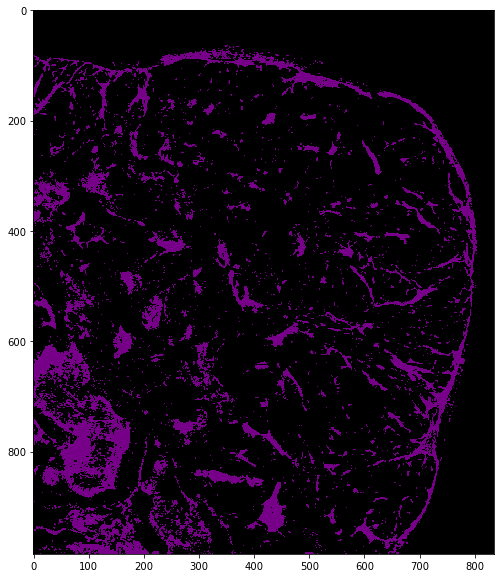

stroma_percentage: 15.181686641379333
number_of_handles (#): 197034.0
connectivity_density (#/mm3): 3031.423994645275


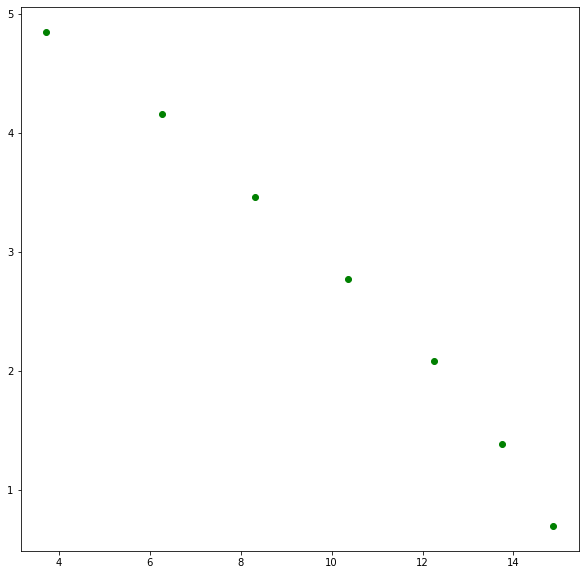

fractal_dimension: -2.6968772209562926


  0%|          | 0/25 [00:00<?, ?it/s]

average_thickness: 23.086677924741174
standard_deviation: 14.973662291829298
----------------------------------------------------------------
done
../../Storage/segmentations/20211020_PDX_STG139_GFP_029621_100x15um.nii


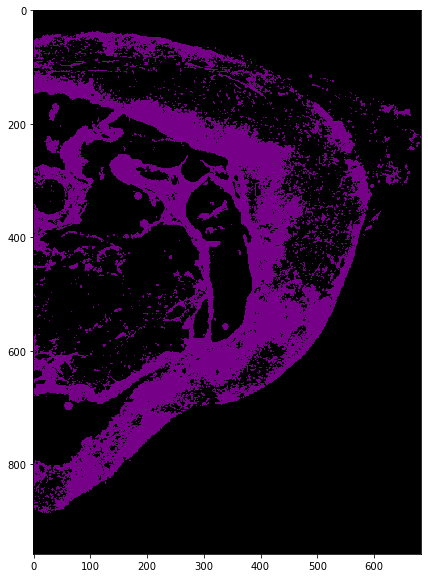

stroma_percentage: 34.1511286858324
number_of_handles (#): 161217.0
connectivity_density (#/mm3): 4762.722879519041


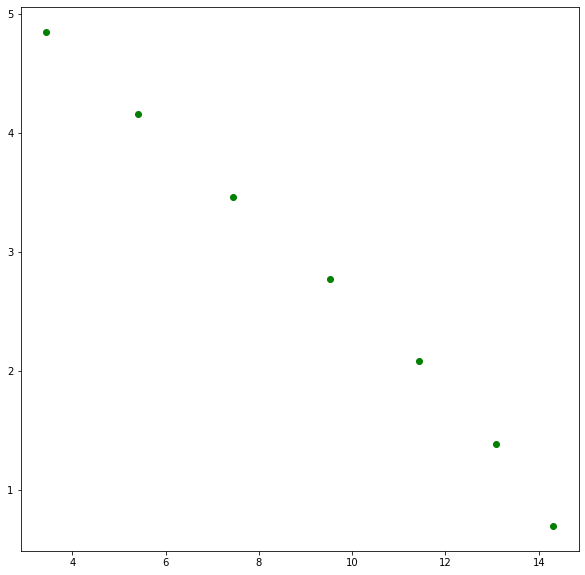

fractal_dimension: -2.6756412101616975


  0%|          | 0/25 [00:00<?, ?it/s]

average_thickness: 48.92873952321493
standard_deviation: 38.36014793229359
----------------------------------------------------------------
done
2


In [11]:
import glob
count = 0
for name in glob.glob("../../Storage/segmentations/*"):
    count = count + 1
    
    RunTotal(name)
print(count)